In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, 
                             precision_recall_curve, plot_precision_recall_curve, f1_score, average_precision_score, 
                             hinge_loss, precision_score, recall_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml, load_iris, make_moons, make_blobs
from sklearn.multiclass import OneVsRestClassifier
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Prezentacja o SVM

Link do prezentacji: https://1drv.ms/p/s!Ap19wJ6OUb8YgYMBlXjB0sOhyxqi0Q

### 2. Przykład działania SVM dla zbiorów WBC (WBreast cancer), MNIST, FMNIST - 500 elementów

In [40]:
# WBC
cancer = load_breast_cancer()

cancer_zipped = list(zip(cancer.data, cancer.target))
cancer_random_sample = random.sample(cancer_zipped, 500)
X, Y = zip(*(cancer_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.94


In [41]:
# MNIST
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

mnist_zipped = list(zip(mnist.data, mnist.target))
mnist_random_sample = random.sample(mnist_zipped, 500)
X, Y = zip(*(mnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.72


In [42]:
# FMNIST
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

fmnist_zipped = list(zip(fmnist.data, fmnist.target))
fmnist_random_sample = random.sample(fmnist_zipped, 500)
X, Y = zip(*(fmnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.62


In [35]:
# Porównianie kerneli dla powyższych zbiorów. 

In [5]:
def accuracy(dataset, kernel):
    dataset_zipped = list(zip(dataset.data, dataset.target))
    dataset_random_sample = random.sample(dataset_zipped, 500)
    X, Y = zip(*(dataset_random_sample))
    X = np.asarray(X)
    Y = np.asarray(Y)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

    clf = SVC(kernel=kernel)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    return accuracy_score(y_test,y_pred)

In [6]:
frame_data = []

for kernel in ('linear', 'poly', 'rbf'):
    frame_data.append([kernel, accuracy(cancer, kernel), accuracy(mnist, kernel), accuracy(fmnist, kernel)])

                  
frame = pd.DataFrame(frame_data, columns=["kernel", "cancer", "mnist", "fmnist"])
frame

,kernel,cancer,mnist,fmnist
0,linear,0.90,0.88,0.7
1,poly,0.96,0.74,0.7
2,rbf,0.84,0.92,0.8


### 3. Krótkie ćwiczenie dla studentów, w którym należy dobrać odpowiednie parametry kernela i uczenia dla wybranych zbiorów danych

In [10]:
# Just util functions. Imagine it's not here :)

data_colors = [(1, 0, 0), (0, 0, 1)]

def read_points_file(filename):
    pts = []
    with open(filename, "r") as f:
        for pt in f:
            pt = pt.strip("\n").split()
            pts.append([float(pt[0]), float(pt[1])])
    return pts


def read_data(class_0_file, class_1_file):
    pts_0 = read_points_file(class_0_file)
    pts_1 = read_points_file(class_1_file)

    x = pts_0 + pts_1
    labels = [0] * len(pts_0) + [1] * len(pts_1)
    x = np.array(x)
    return (x, labels)


def plot_data(X_train, y_train, X_test, y_test):

    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))

    colors = get_colors(y)
    colors_train = get_colors(y_train)
    colors_test = get_colors(y_test)


    plt.figure(figsize=(12, 4))

    # Plot all data plot
    plt.subplot(131)
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c = colors, s = 10, edgecolors=colors)
    plt.title("Data (100%)")

    # training data plot
    plt.subplot(132)
    plt.axis('equal')
    plt.scatter(X_train[:, 0], X_train[:, 1], c = colors_train, s = 10, edgecolors=colors_train)
    plt.title("Training Data (80%)")

    # testing data plot
    plt.subplot(133)
    plt.axis('equal')
    plt.scatter(X_test[:, 0], X_test[:, 1], c = colors_test, s = 10, edgecolors=colors_test)
    plt.title("Test Data (20%)")
    plt.tight_layout()

    plt.show()

    
def get_colors(y):
    return [data_colors[int(item)] for item in y]


def plot_decision_function(X_train, y_train, X_test, y_test, clf):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.title("Training data")
    plot_decision_function_helper(X_train, y_train, clf)
    plt.subplot(122)
    plt.title("Test data")
    plot_decision_function_helper(X_test, y_test, clf, True)
    plt.show()


def plot_decision_function_helper(X, y, clf, show_only_decision_function = False):
    colors = get_colors(y)
    plt.axis('equal')
    plt.tight_layout()

    plt.scatter(X[:, 0], X[:, 1], c = colors, s = 10, edgecolors=colors)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    
def generate_train_set(X,Y):
    return train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state = 42)


def do_svm(train_X, test_X, train_Y, test_Y, plot=True, **kwargs):
    clf = SVC(**kwargs)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(test_X)
    if plot:
        plot_decision_function(train_X, train_Y, test_X, test_Y, clf)
    print("Accuracy: " + str(accuracy_score(test_Y, y_pred)))

Zaobserwuj poniższy zbiór danych o dwóch cechach i w następnym kroku postaraj się wybrać odpowiednie parametry dla SVM

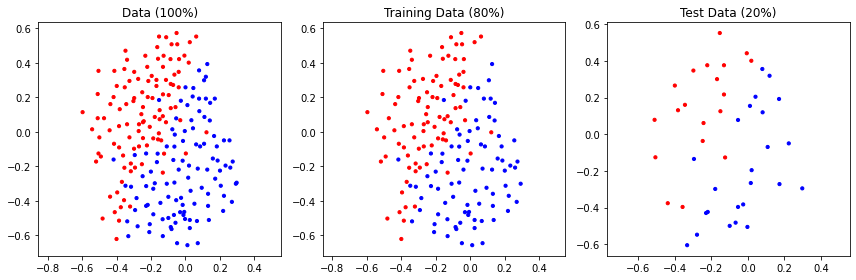

In [11]:
X, y = read_data("custom_datasets/1/points_class_0.txt", "custom_datasets/1/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność. Wypróbuj wszystkie parametry, postaraj się zauważyć jak zmienia się wybrana hiperpłaszczyzna.

**Kernel** = wybierz jedno z: linear, poly, rbf, sigmoid

**C** = liczba rzeczywista

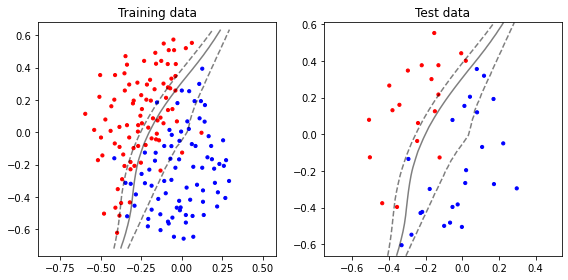

Accuracy: 0.9534883720930233


In [13]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='poly', C=10)

Zrób to samo co wcześniej, ale dla innego rodzaju danych

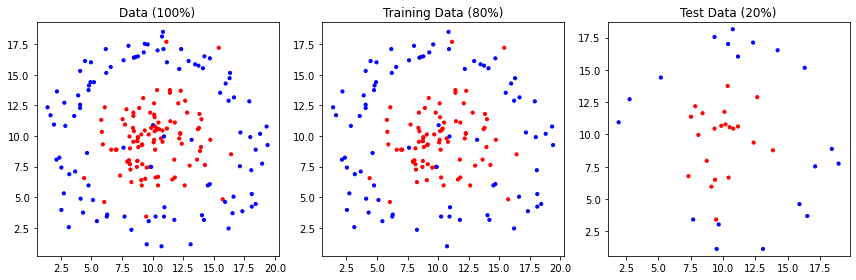

In [25]:
X, y = read_data("custom_datasets/2/points_class_0.txt", "custom_datasets/2/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność.

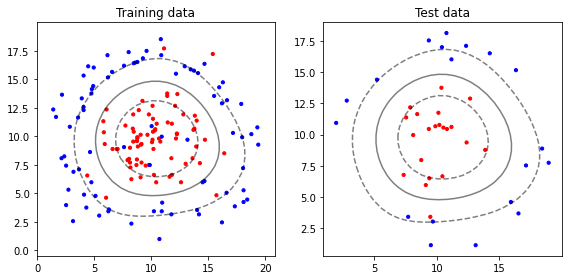

Accuracy: 0.975


In [26]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='rbf', C=1)

Ostatni raz, zrób to samo co wcześniej, ale dla jeszcze innego rodzaju danych

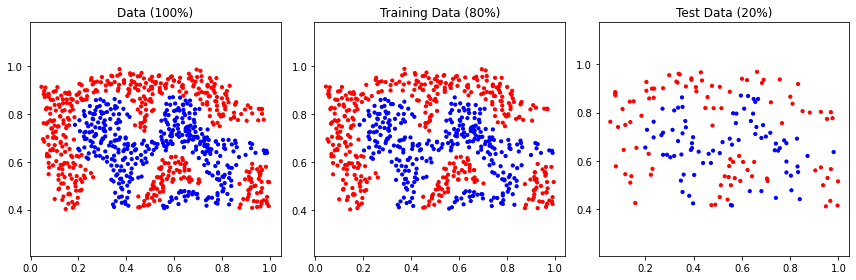

In [27]:
X, y = read_data("custom_datasets/3/points_class_0.txt", "custom_datasets/3/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność.

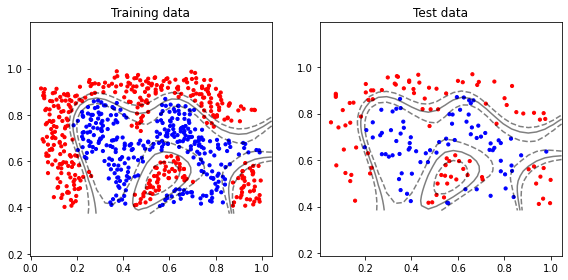

Accuracy: 0.953757225433526


In [34]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='rbf',C=100)

### 4. Omówienie accuracy, cross validation, loss, ROC curve, PR curve

Także w tej samej prezentacji: https://1drv.ms/p/s!Ap19wJ6OUb8YgYMBlXjB0sOhyxqi0Q

### 5. Wizualizacja accuracy, cross validation, loss, ROC curve, PR curve dla zbioru WBC

In [98]:
cancer = load_breast_cancer()

X, y = (cancer.data, cancer.target)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [99]:
# accuracy:
clf = SVC(kernel='linear', probability=True)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy = {accuracy_score(y_test,y_pred)}')

accuracy = 0.9370629370629371


In [54]:
#cross validation
scores = cross_val_score(clf, X, y, cv=5)
print(f'cross validations scores:{scores}')

cross validations scores:[0.94736842 0.92982456 0.97368421 0.92105263 0.95575221]


In [55]:
#loss użyto funkcji hinge która jest stosowana w SVM
print(f'hinge function loss: {hinge_loss(y_test, y_pred)}')

hinge function loss: 0.45454545454545453


In [56]:
# precision score
print(f'precision score: {precision_score(y_test, y_pred)}')

precision score: 0.9534883720930233


In [57]:
# recall score
print(f'recall score: {recall_score(y_test, y_pred)}')

recall score: 0.9425287356321839


In [58]:
# f1 score
print(f'f1 score: {f1_score(y_test, y_pred)}')

f1 score: 0.9479768786127168


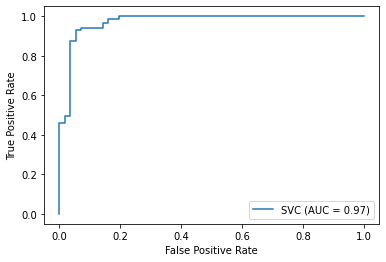

In [59]:
# ROC curve
# Binarize the output
svc_disp = plot_roc_curve(clf, x_test, y_test)
plt.show()

Average precision score, micro-averaged over all classes: 0.96


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.96')

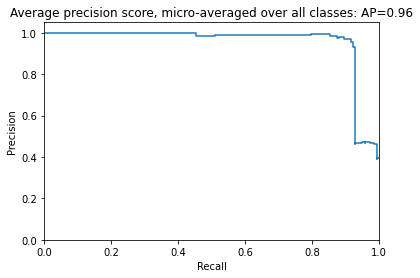

In [60]:
# PR_curve
y_binarized = label_binarize(y, classes=[0, 1, 2])
n_classes = y_binarized.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y_binarized, train_size=0.75)

# Run classifier
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

### 5. Zadania

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from imgaug import augmenters as iaa

a. Na zbiorach MNIST, FMNIST, TNG (twenty news groups) zaprezentować działanie
klasyfikatora SVM i wyniki porównać do klasyfikatora k-NN przy pomocy poznanych miar
walidacji klasyfikacji. (dla najlepszej konfiguracji, stałej uczenia, funkcji kernela)

In [43]:
def svm_classifier(X_train, X_test, y_train, kernel='rbf'):
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf

def knn_classifier(X_train, X_test, y_train, n=3):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf

def compare(X, y, svm_kernel='rbf', knn_n=3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=212)
    y_predicted_svm, svm_clf = svm_classifier(X_train, X_test, y_train, kernel=svm_kernel)
    y_predicted_knn, knn_clf = knn_classifier(X_train, X_test, y_train, n=knn_n)

    results = pd.DataFrame(columns=['measure', 'svm', 'knn'])
    results.loc[0] = ['accuracy', accuracy_score(y_test, y_predicted_svm), accuracy_score(y_test, y_predicted_knn)]
    results.loc[1] = ['precision', precision_score(y_test, y_predicted_svm, average='macro'), precision_score(y_test, y_predicted_knn, average='macro')]
    results.loc[2] = ['recall', recall_score(y_test, y_predicted_svm, average='macro'), recall_score(y_test, y_predicted_knn, average='macro')]
    results.loc[3] = ['avg cross validation', np.average(cross_val_score(svm_clf, X, y, cv=5)), np.average(cross_val_score(knn_clf, X, y, cv=5))]
    return results

In [44]:
def get_part(X, y, p):
    zipped = list(zip(X,y))
    taken = int(p*len(zipped))
    print("Selected {0} examples".format(taken))
    selected = random.sample(zipped, taken)
    X, Y = zip(*(selected))
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [48]:
X, y = get_part(mnist.data, mnist.target, 0.1)
results = compare(X, y)
print("MNIST comparision")
results

Selected 7000 examples
MNIST comparision


,measure,svm,knn
0,accuracy,0.951429,0.939286
1,precision,0.951226,0.941405
2,recall,0.949862,0.936914
3,avg cross validation,0.958000,0.938000


In [49]:
X, y = get_part(fmnist.data, fmnist.target, 0.1)
results = compare(X, y)
print("FMNIST comparision")
results

Selected 7000 examples
FMNIST comparision


,measure,svm,knn
0,accuracy,0.835714,0.803571
1,precision,0.835139,0.812526
2,recall,0.837740,0.806095
3,avg cross validation,0.844571,0.807000


In [47]:
TNG_path = './TNG/ng20.csv'
pdTNG = pd.read_csv(TNG_path, header=None)
X = np.array(pdTNG[range(0,128)])
y = np.array(pdTNG[128])
compare(X, y, svm_kernel='linear')

,measure,svm,knn
0,accuracy,0.797524,0.796640
1,precision,0.791966,0.794929
2,recall,0.788868,0.786470
3,avg cross validation,0.794838,0.773966


b. Zaproponować, taką augmentację zbiorów treningowych (wielkość zbioru zależna od
mocy obliczeniowej którą Państwo dysponują) aby uzyskać jak najlepsze miary jakości na
zbiorach testowych.

Selected 2100 examples
1


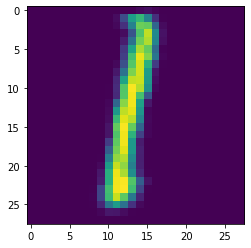

In [236]:
X, y = get_part(mnist.data, mnist.target, 0.03)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=212)

seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.5*255), per_channel=0.5)),
#    iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0.0, 2.0))),
    iaa.Crop(px=(0,3)),
    iaa.Affine(rotate=(-15, 15))
])

images = [np.array(i, dtype='float32').reshape(28,28) for i in X_train]
images = seq(images=images)
noised_train = np.array([im.reshape(784) for im in images])
plt.imshow(noised_train[22].reshape(28,28))
print(y_train[22])
X_train_aug = np.append(X_train, noised_train, axis=0)
y_train_aug = np.append(y_train, y_train, axis=0)

In [237]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

clf_aug = SVC(kernel='rbf')
clf_aug.fit(X_train_aug, y_train_aug)
y_predicted_aug = clf_aug.predict(X_test)

results = pd.DataFrame(columns=['measure', 'without aug', 'aug'])
results.loc[0] = ['accuracy', accuracy_score(y_test, y_predicted), accuracy_score(y_test, y_predicted_aug)]
results.loc[1] = ['precision', precision_score(y_test, y_predicted, average='macro'), precision_score(y_test, y_predicted_aug, average='macro')]
results.loc[2] = ['recall', recall_score(y_test, y_predicted, average='macro'), recall_score(y_test, y_predicted_aug, average='macro')]
#results.loc[3] = ['cross_val', cross_val_score(clf, X, y, cv=5), cross_val_score(clf_aug, X, y, cv=5)]
results

,measure,without aug,aug
0,accuracy,0.914286,0.928571
1,precision,0.913093,0.929621
2,recall,0.912738,0.926202
